In [ ]:
# Jason Hemedinger
# Argonne National Laboratory


In [1]:
import pyart, boto3, tempfile, os, shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import animation
from botocore.handlers import disable_signing
from tint import Cell_tracks
from tint import animate as tint_animate
from tint.visualization import embed_mp4_as_gif
from glob import glob
from datetime import datetime
from pylab import *


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
def get_current_scan(station_date, key_index):
    '''
    Function will pull the latest radar scan from any radar site using 
    Amazon S3.
    ----------
    station_date= 'year/month/day/station'
    year = YYYY e.g. 1776
    month = mm e.g. 07
    day = dd e.g. 04
    site = xxxx e.g. kdix
    '''
    bucket = 'noaa-nexrad-level2'
    s3 = boto3.resource('s3')
    s3.meta.client.meta.events.register('choose-signer.s3.*', disable_signing)
    
    aws_radar = s3.Bucket(bucket)
    
    for obj in aws_radar.objects.filter(Prefix= station_date):
        '{0}:{1}'.format(aws_radar.name, obj.key)
    my_list_of_keys = [this_object.key for this_object in aws_radar.objects.filter(Prefix= station_date)]
    keys = my_list_of_keys[key_index:]
    print(my_list_of_keys[key_index:])
    
    
    return aws_radar, keys

In [73]:
#setting the radar site and which keys to pull.
aws_radar, keys = get_current_scan('2018/06/26/KLOT', key_index=-11)

['2018/06/26/KLOT/KLOT20180626_223928_V06', '2018/06/26/KLOT/KLOT20180626_224650_V06', '2018/06/26/KLOT/KLOT20180626_225415_V06', '2018/06/26/KLOT/KLOT20180626_230137_V06', '2018/06/26/KLOT/KLOT20180626_230901_V06', '2018/06/26/KLOT/KLOT20180626_231625_V06', '2018/06/26/KLOT/KLOT20180626_232348_V06', '2018/06/26/KLOT/KLOT20180626_233110_V06', '2018/06/26/KLOT/KLOT20180626_233834_V06', '2018/06/26/KLOT/KLOT20180626_234558_V06', '2018/06/26/KLOT/KLOT20180626_235323_V06']


In [34]:
new_key = keys[-11]
print(new_key)

2018/06/26/KLOT/KLOT20180626_223928_V06


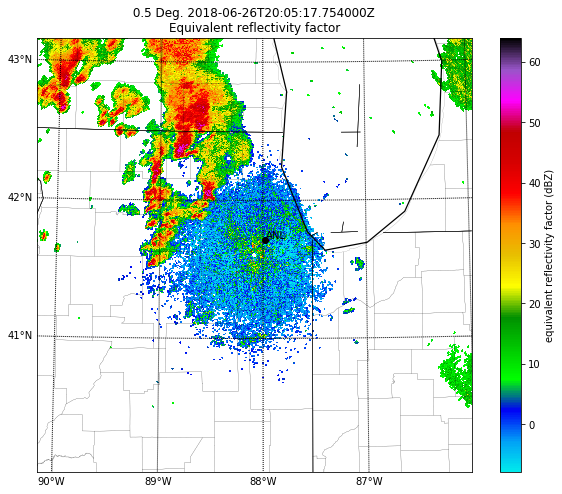

In [4]:
#animating using matplotlib and pyart
def animate(nframe):
    plt.clf()
    localfile = tempfile.NamedTemporaryFile()
    aws_radar.download_file(keys[nframe], localfile.name)
    radar = pyart.io.read(localfile.name)
    display = pyart.graph.RadarMapDisplay(radar)
    # Delete radar after use to save memory.
    del radar
    display.plot_ppi_map('reflectivity', sweep=0, resolution='l',
                         vmin=-8, vmax=64, mask_outside=False, 
                         fig=fig, width=350000, height=350000)
    display.basemap.drawcounties()
    display.plot_point(-87.981810, 41.713969 , label_text='ANL', symbol='ko')
#    display.plot_point(-87.04361, 41.46361, label_text='VU', color='k')
fig = plt.figure(figsize=(10, 8))
anim_klot = animation.FuncAnimation(fig, animate,
                                    frames=len(keys))
anim_klot.save('reflectivity_animation.gif', 
               writer='imagemagick', fps=2)
plt.show()
plt.close()

In [5]:
out_path_dir = '/home/jhemedinger/suli_projects/chicago-nowcast/events/2018_06_26/testing'
#out_path_dir = '/home/jhemedinger/suli_projects/chicago-nowcast/events/2018_06_26/20180626-22Z'
#out_path_dir2 = '/home/jhemedinger/suli_projects/chicago-nowcast/events/2018_06_26/20180626-23Z'

In [6]:
#turing the data into grid data and saving it to a folder
def get_grid(aws_radar, key):
    localfile = tempfile.NamedTemporaryFile()
    aws_radar.download_file(key, localfile.name)
    radar = pyart.io.read(localfile.name)
    grid = pyart.map.grid_from_radars(
            radar, grid_shape=(31, 401, 401),
            grid_limits=((0, 15000), (-200000, 200000), (-200000, 200000)),
            fields=['reflectivity'], gridding_algo='map_gates_to_grid',
            h_factor=0., nb=0.6, bsp=1., min_radius=200.)
    return grid

#out_path_dir = '/home/jhemedinger/suli_projects/chicago-nowcast/events

for num,key in enumerate(keys):
    print('saving grid', num)
    grid = get_grid(aws_radar, key)
    name = os.path.join(out_path_dir, 'grid_' + str(num).zfill(3) + '.nc')
    pyart.io.write_grid(name, grid)
    del grid

saving grid 0
saving grid 1
saving grid 2
saving grid 3
saving grid 4
saving grid 5
saving grid 6
saving grid 7
saving grid 8
saving grid 9
saving grid 10
saving grid 11
saving grid 12
saving grid 13
saving grid 14
saving grid 15
saving grid 16
saving grid 17
saving grid 18
saving grid 19
saving grid 20
saving grid 21
saving grid 22
saving grid 23
saving grid 24
saving grid 25
saving grid 26
saving grid 27
saving grid 28
saving grid 29
saving grid 30
saving grid 31
saving grid 32
saving grid 33
saving grid 34
saving grid 35


In [7]:
#files_2 = [os.path.join(out_dir, fn) for fn in os.listdir(out_dir)]
files = glob(out_path_dir + '/grid_*')
files.sort()

In [8]:
grid_gen = (pyart.io.read_grid(f) for f in files)
#grid_list = [pyart.io.read_grid(f) for f in files]

In [9]:
tracks_obj = Cell_tracks()
tracks_obj.get_tracks(grid_gen)

Writing tracks for scan 0
Writing tracks for scan 1
Writing tracks for scan 2
Writing tracks for scan 3
Writing tracks for scan 4
Writing tracks for scan 5
Writing tracks for scan 6
Writing tracks for scan 7
Writing tracks for scan 8
Writing tracks for scan 9
Writing tracks for scan 10
Writing tracks for scan 11
Writing tracks for scan 12
Writing tracks for scan 13
Writing tracks for scan 14
Writing tracks for scan 15
Writing tracks for scan 16
Writing tracks for scan 17
Writing tracks for scan 18
Writing tracks for scan 19
Writing tracks for scan 20
Writing tracks for scan 21
Writing tracks for scan 22
Writing tracks for scan 23
Writing tracks for scan 24
Writing tracks for scan 25
Writing tracks for scan 26
Writing tracks for scan 27
Writing tracks for scan 28
Writing tracks for scan 29
Writing tracks for scan 30
Writing tracks for scan 31
Writing tracks for scan 32
Writing tracks for scan 33
Writing tracks for scan 34
Writing tracks for scan 35


time elapsed 0.6 minutes


In [79]:
tracks_obj.params
#tracks_obj.params['FIELD_THRESH': 35]

{'FIELD_THRESH': 32,
 'FLOW_MARGIN': 10000,
 'GS_ALT': 1500,
 'ISO_SMOOTH': 3,
 'ISO_THRESH': 8,
 'MAX_DISPARITY': 999,
 'MAX_FLOW_MAG': 50,
 'MAX_SHIFT_DISP': 15,
 'MIN_SIZE': 8,
 'SEARCH_MARGIN': 4000}

In [10]:
tracks_obj.tracks

time   grid_x   grid_y      lon      lat    area  \
scan uid                                                                   
0    0   2018-06-26 20:05:17  119.375  195.400 -89.0579  41.5554    40.0   
     1   2018-06-26 20:05:17  122.056  214.019 -89.0244  41.7265    54.0   
     2   2018-06-26 20:05:17  124.750  210.250 -88.9877  41.6908     8.0   
     3   2018-06-26 20:05:17  132.400  218.500 -88.9043  41.7634    10.0   
     4   2018-06-26 20:05:17  118.024  225.878 -89.0742  41.8340    41.0   
     5   2018-06-26 20:05:17  132.035  226.588 -88.9054  41.8443    85.0   
     6   2018-06-26 20:05:17  155.234  233.766 -88.6282  41.9089    47.0   
     7   2018-06-26 20:05:17  132.667  234.952 -88.8942  41.9164    21.0   
     8   2018-06-26 20:05:17  120.638  247.444 -89.0408  42.0232   207.0   
     9   2018-06-26 20:05:17  166.015  252.227 -88.4964  42.0714   273.0   
     10  2018-06-26 20:05:17   15.130  243.739 -90.3227  41.9785    23.0   
     11  2018-06-26 20:05:17  122.755  274.745 -89.0203  42.2752   196.0   
     12  2018-06-26 20:05:17  164.000  270.636 -88.5218  42.2421    11.0   
     13  2018-06-26 20:05:17  169.500  274.400 -88.4490  42.2694    10.0   
     14  2018-06-26 20:05:17  191.667  275.778 -88.1817  42.2879     9.0   
     15  2018-06-26 20:05:17  150.562  314.735 -88.6834  42.6371  1512.0   
     16  2018-06-26 20:05:17  194.034  282.724 -88.1575  42.3509    29.0   
     17  2018-06-26 20:05:17    4.727  291.682 -90.4597  42.4076    22.0   
     18  2018-06-26 20:05:17    0.684  295.684 -90.5098  42.4425    19.0   
     19  2018-06-26 20:05:17  166.545  296.273 -88.4867  42.4671    22.0   
     20  2018-06-26 20:05:17   12.226  299.038 -90.3768  42.4722    53.0   
     21  2018-06-26 20:05:17   92.500  301.500 -89.4021  42.5143    22.0   
     22  2018-06-26 20:05:17  101.111  300.444 -89.2920  42.4975     9.0   
     23  2018-06-26 20:05:17    3.520  309.760 -90.4781  42.5691    25.0   
     24  2018-06-26 20:05:17   79.189  311.378 -89.5626  42.5933    37.0   
     25  2018-06-26 20:05:17   90.434  315.340 -89.4290  42.6309    53.0   
     26  2018-06-26 20:05:17   47.597  346.740 -89.9508  42.9115   678.0   
     27  2018-06-26 20:05:17   76.667  326.407 -89.5903  42.7279    27.0   
     28  2018-06-26 20:05:17  105.143  325.238 -89.2474  42.7228    21.0   
     29  2018-06-26 20:05:17   24.818  334.455 -90.2291  42.7898    11.0   
...                      ...      ...      ...      ...      ...     ...   
35   441 2018-06-26 23:53:23  140.872  228.362 -88.7968  41.8541    47.0   
     375 2018-06-26 23:53:23   26.653  238.803 -90.1761  41.9363   193.0   
     442 2018-06-26 23:53:23  174.366  235.296 -88.3987  41.9188    71.0   
     388 2018-06-26 23:53:23  108.921  237.809 -89.1847  41.9410    89.0   
     92  2018-06-26 23:53:23  210.749  307.498 -87.9501  42.5666  6647.0   
     478 2018-06-26 23:53:23  221.308  234.692 -87.8306  41.9189    13.0   
     479 2018-06-26 23:53:23  198.111  241.222 -88.1086  41.9732     9.0   
     444 2018-06-26 23:53:23  187.859  247.352 -88.2297  42.0270    71.0   
     480 2018-06-26 23:53:23  176.714  252.000 -88.3631  42.0718    35.0   
     481 2018-06-26 23:53:23  192.643  255.786 -88.1693  42.1080    14.0   
     427 2018-06-26 23:53:23  149.214  258.357 -88.7028  42.1244    14.0   
     463 2018-06-26 23:53:23  132.138  261.655 -88.9094  42.1591    29.0   
     482 2018-06-26 23:53:23  141.771  273.758 -88.7893  42.2678   231.0   
     483 2018-06-26 23:53:23   51.444  263.611 -89.8924  42.1659    18.0   
     446 2018-06-26 23:53:23  229.862  264.738 -87.7203  42.1884    65.0   
     168 2018-06-26 23:53:23   65.404  273.637 -89.7249  42.2584   146.0   
     464 2018-06-26 23:53:23   81.767  292.400 -89.5220  42.4229    30.0   
     484 2018-06-26 23:53:23  126.167  314.083 -88.9889  42.6262    12.0   
     465 2018-06-26 23:53:23  132.458  319.521 -88.9163  42.6807    48.0   
     466 2018-06-26 23:53:23  171.591  329.773 -88.4275  42.7731    44.0

In [11]:
if os.path.exists(out_path_dir + '/test_animation.mp4'):
    print(out_path_dir + '/test_animation.mp4'
          + ' already exists, removing file')
    os.remove(out_path_dir + '/test_animation.mp4')

/home/jhemedinger/suli_projects/chicago-nowcast/events/2018_06_26/testing/test_animation.mp4 already exists, removing file


In [12]:
grid_gen = (pyart.io.read_grid(f) for f in files)
tint_animate(tracks_obj, grid_gen, os.path.join(out_path_dir, 'test_animation'), tracers=True)

foobar
Animating 36 frames
Frame: 0
reflectivity 3
-8 64
Frame: 1
reflectivity 3
-8 64
Frame: 2
reflectivity 3
-8 64
Frame: 3
reflectivity 3
-8 64
Frame: 4
reflectivity 3
-8 64
Frame: 5
reflectivity 3
-8 64
Frame: 6
reflectivity 3
-8 64
Frame: 7
reflectivity 3
-8 64
Frame: 8
reflectivity 3
-8 64
Frame: 9
reflectivity 3
-8 64
Frame: 10
reflectivity 3
-8 64
Frame: 11
reflectivity 3
-8 64
Frame: 12
reflectivity 3
-8 64
Frame: 13
reflectivity 3
-8 64
Frame: 14
reflectivity 3
-8 64
Frame: 15
reflectivity 3
-8 64
Frame: 16
reflectivity 3
-8 64
Frame: 17
reflectivity 3
-8 64
Frame: 18
reflectivity 3
-8 64
Frame: 19
reflectivity 3
-8 64
Frame: 20
reflectivity 3
-8 64
Frame: 21
reflectivity 3
-8 64
Frame: 22
reflectivity 3
-8 64
Frame: 23
reflectivity 3
-8 64
Frame: 24
reflectivity 3
-8 64
Frame: 25
reflectivity 3
-8 64
Frame: 26
reflectivity 3
-8 64
Frame: 27
reflectivity 3
-8 64
Frame: 28
reflectivity 3
-8 64
Frame: 29
reflectivity 3
-8 64
Frame: 30
reflectivity 3
-8 64
Frame: 31
reflectivity

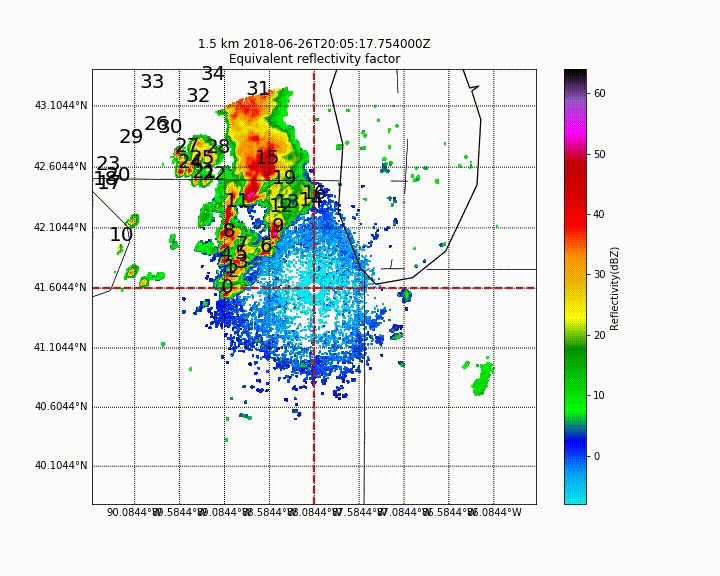

In [13]:
embed_mp4_as_gif(out_path_dir + '/test_animation.mp4')

In [14]:
cells = tracks_obj.tracks.groupby(level='uid')
#cells2 = tracks_obj2.tracks.groupby(level='uid')
for uid in cells:
    print(uid)

('0',                         time   grid_x   grid_y      lon      lat   area  \
scan uid                                                                  
0    0   2018-06-26 20:05:17  119.375  195.400 -89.0579  41.5554   40.0   
1    0   2018-06-26 20:10:34  121.280  197.640 -89.0343  41.5825   50.0   
2    0   2018-06-26 20:15:59  123.554  200.946 -88.9986  41.6098   56.0   
3    0   2018-06-26 20:21:24  125.426  204.066 -88.9869  41.6369   61.0   
4    0   2018-06-26 20:26:59  124.581  206.767 -88.9873  41.6639   43.0   
5    0   2018-06-26 20:32:33  125.842  209.684 -88.9757  41.6909   38.0   
6    0   2018-06-26 20:38:00  127.963  212.704 -88.9519  41.7181   27.0   
7    0   2018-06-26 20:44:00  129.300  216.333 -88.9402  41.7452   30.0   
8    0   2018-06-26 20:49:48  131.212  219.242 -88.9165  41.7723   33.0   
9    0   2018-06-26 20:55:27  132.162  220.486 -88.9045  41.7814   37.0   
10   0   2018-06-26 21:02:28  136.069  223.448 -88.8566  41.8087   58.0   
11   0   2018-06-26

13   151  42.696377      5.0     False  )
('152',                         time  grid_x   grid_y      lon      lat  area   vol  \
scan uid                                                                      
13   152 2018-06-26 21:21:05  59.944  281.278 -89.7873  42.3204  18.0  39.5   
14   152 2018-06-26 21:27:39  64.875  285.750 -89.7277  42.3662   8.0  15.0   

                max  max_alt  isolated  
scan uid                                
13   152  36.204266      4.5     False  
14   152  33.264690      4.0     False  )
('153',                         time   grid_x   grid_y      lon      lat  area   vol  \
scan uid                                                                       
13   153 2018-06-26 21:21:05  197.983  287.695 -88.1088  42.3958  59.0  76.5   

                max  max_alt  isolated  
scan uid                                
13   153  38.370007      4.5     False  )
('154',                         time   grid_x   grid_y      lon      lat  area   vol  \
scan ui

('208',                         time   grid_x   grid_y      lon      lat  area   vol  \
scan uid                                                                       
16   208 2018-06-26 21:40:20  211.000  307.870 -87.9501  42.5756  23.0  29.0   
17   208 2018-06-26 21:46:41  216.714  313.143 -87.8767  42.6205  14.0  13.5   
18   208 2018-06-26 21:53:03  221.600  318.267 -87.8154  42.6653  15.0  23.5   
19   208 2018-06-26 21:59:25  225.364  323.545 -87.7784  42.7192  11.0  12.5   

                max  max_alt  isolated  
scan uid                                
16   208  34.802238      4.5     False  
17   208  33.179153      4.5     False  
18   208  34.839485      4.5     False  
19   208  34.896591      4.5     False  )
('209',                         time   grid_x   grid_y      lon      lat  area  vol  \
scan uid                                                                      
16   209 2018-06-26 21:40:20  158.111  318.778 -88.5982  42.6735   9.0  9.5   

               max

24   270  33.818806      4.0     False  )
('271',                         time   grid_x   grid_y      lon      lat  area  vol  \
scan uid                                                                      
21   271 2018-06-26 22:12:20  194.444  155.222 -88.1562  41.1997   9.0  6.0   

                max  max_alt  isolated  
scan uid                                
21   271  36.051361      3.5     False  )
('272',                         time   grid_x   grid_y      lon      lat  area   vol  \
scan uid                                                                       
21   272 2018-06-26 22:12:20  172.500  167.857 -88.4197  41.3162  14.0  14.5   
22   272 2018-06-26 22:18:54  175.622  171.919 -88.3720  41.3523  37.0  56.5   

                max  max_alt  isolated  
scan uid                                
21   272  46.043026      4.5     False  
22   272  52.412590      4.5     False  )
('273',                         time  grid_x   grid_y      lon      lat  area    vol  \
scan u

26   331  42.701622      5.0      True  )
('332',                         time  grid_x   grid_y      lon      lat  area   vol  \
scan uid                                                                      
26   332 2018-06-26 22:46:50  59.083  223.583 -89.7857  41.8078  12.0  35.0   
27   332 2018-06-26 22:54:15  62.000  227.000 -89.7503  41.8353  11.0  33.0   
28   332 2018-06-26 23:01:37  65.000  230.167 -89.7147  41.8628  12.0  35.5   
29   332 2018-06-26 23:09:01  68.368  233.421 -89.6792  41.8902  19.0  54.0   

                max  max_alt  isolated  
scan uid                                
26   332  41.733974      4.0     False  
27   332  39.374619      5.5     False  
28   332  41.351227      5.0     False  
29   332  39.946846      5.0     False  )
('333',                         time  grid_x   grid_y      lon      lat  area  vol  \
scan uid                                                                     
26   333 2018-06-26 22:46:50  95.125  251.625 -89.3564  42.0651 

2    40   39.274502      4.5     False  )
('400',                         time  grid_x   grid_y      lon      lat  area    vol  \
scan uid                                                                       
31   400 2018-06-26 23:23:48   2.310  159.966 -90.4520  41.2203  29.0   75.5   
32   400 2018-06-26 23:31:10   6.000  162.244 -90.4049  41.2393  45.0  140.0   
33   400 2018-06-26 23:38:34   8.053  163.447 -90.3813  41.2488  38.0  106.5   
34   400 2018-06-26 23:45:58  10.750  164.900 -90.3460  41.2675  40.0  100.0   
35   400 2018-06-26 23:53:23  15.962  170.731 -90.2881  41.3225  26.0   59.0   

                max  max_alt  isolated  
scan uid                                
31   400  43.055603      6.0      True  
32   400  51.816624      5.5     False  
33   400  40.972904      5.5     False  
34   400  39.618671      5.0     False  
35   400  38.719028      5.0     False  )
('401',                         time  grid_x   grid_y      lon      lat  area  vol  \
scan uid       

1    47   37.999901      3.5     False  )
('470',                         time   grid_x   grid_y      lon      lat  area   vol  \
scan uid                                                                       
34   470 2018-06-26 23:45:58  241.231  370.615 -87.5792  43.1412  13.0  22.5   

                max  max_alt  isolated  
scan uid                                
34   470  33.122768      4.0     False  )
('471',                         time   grid_x   grid_y    lon      lat  area   vol  \
scan uid                                                                     
34   471 2018-06-26 23:45:58  249.462  377.692 -87.48  43.2037  13.0  29.0   

                max  max_alt  isolated  
scan uid                                
34   471  36.631233      4.5     False  )
('472',                         time  grid_x  grid_y      lon      lat  area    vol  \
scan uid                                                                      
35   472 2018-06-26 23:53:23  375.56  52.179 -86.010

9    95   49.500000      5.0     False  )
('96',                         time  grid_x   grid_y      lon      lat   area    vol  \
scan uid                                                                        
6    96  2018-06-26 20:38:00   0.846  277.500 -90.5036  42.2807   26.0   76.0   
7    96  2018-06-26 20:44:00   1.360  276.320 -90.5029  42.2627   25.0   75.0   
8    96  2018-06-26 20:49:48   3.661  279.593 -90.4678  42.2994   59.0  142.5   
9    96  2018-06-26 20:55:27   6.482  283.000 -90.4445  42.3269   83.0  221.5   
10   96  2018-06-26 21:02:28   8.062  284.204 -90.4206  42.3364  113.0  305.0   
11   96  2018-06-26 21:08:35  11.811  286.470 -90.3726  42.3553  132.0  349.5   
12   96  2018-06-26 21:14:43  14.241  287.593 -90.3489  42.3738  108.0  287.0   
13   96  2018-06-26 21:21:05  16.112  289.402 -90.3249  42.3832  107.0  268.0   
14   96  2018-06-26 21:27:39  22.135  294.288 -90.2534  42.4296   52.0  141.0   
15   96  2018-06-26 21:34:00  23.242  294.909 -90.2415  42.4

In [15]:
tracks_obj.tracks.groupby(level='uid').size().sort_values(ascending=False)[:]

uid
26     36
92     30
49     27
132    24
168    22
193    20
66     18
0      18
244    17
51     16
10     16
114    15
38     15
163    15
94     13
276    13
162    13
316    11
295    11
96     11
204    11
59     11
9      11
105    10
179    10
28     10
5      10
27     10
161    10
150    10
       ..
487     1
344     1
345     1
346     1
348     1
349     1
351     1
352     1
353     1
354     1
336     1
334     1
306     1
333     1
50      1
311     1
312     1
313     1
490     1
98      1
320     1
322     1
489     1
326     1
327     1
329     1
488     1
330     1
331     1
319     1
Length: 491, dtype: int64

In [16]:
df_193 = pd.DataFrame(tracks_obj.tracks.xs('193', level='uid'))
lons, lats = np.array(df_193['lon']), np.array(df_193['lat'])
time = np.array(pd.to_datetime(df_193['time']))
time_f10 = time[:10]
time_l10 = time[-10:]
lon_f10 = lons[:10]
lat_f10 = lats[:10]
lon_l10 = lons[-10:]
lat_l10 = lats[-10:]

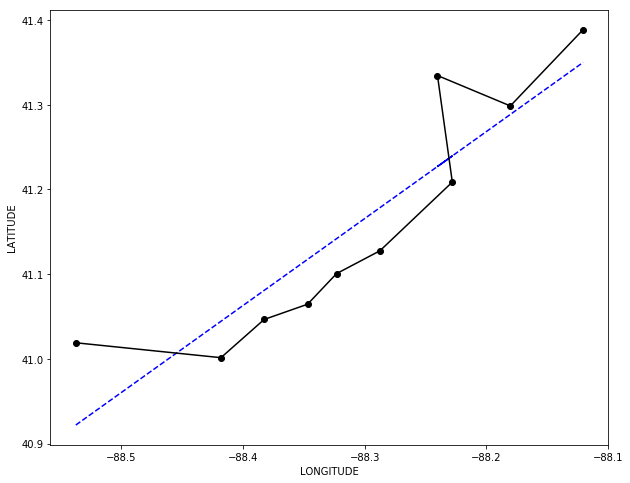

In [17]:
#df_150 = pd.DataFrame(tracks_obj.tracks.xs('150', level='uid'))
#lons, lats = df_150['lon'], df_150['lat']
#time = pd.to_numeric(df_150['time'])
#time = pd.to_datetime(time)
#time = np.array(pd.to_datetime(df_150['time']))

fit = polyfit(lon_f10,lat_f10,1)
fit_fn = poly1d(fit)

fig = plt.figure(figsize=(10,8))
plt.plot(lon_f10, fit_fn(lon_f10), '--b')
plt.plot(lon_f10, lat_f10, color='k', marker='o')
#plt.plot(-87.981810, 41.713969, color='r', marker='*')
plt.xlabel('LONGITUDE')
plt.ylabel('LATITUDE')
plt.show()
plt.close()

In [18]:
print(time_f10)

['2018-06-26T21:40:20.000000000' '2018-06-26T21:46:41.000000000'
 '2018-06-26T21:53:03.000000000' '2018-06-26T21:59:25.000000000'
 '2018-06-26T22:05:46.000000000' '2018-06-26T22:12:20.000000000'
 '2018-06-26T22:18:54.000000000' '2018-06-26T22:25:28.000000000'
 '2018-06-26T22:32:05.000000000' '2018-06-26T22:39:28.000000000']


In [19]:
ts = (time_f10 - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')

/home/jhemedinger/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  """Entry point for launching an IPython kernel.


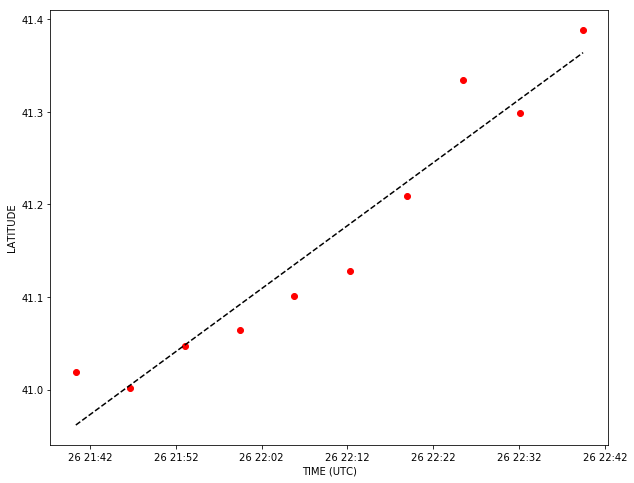

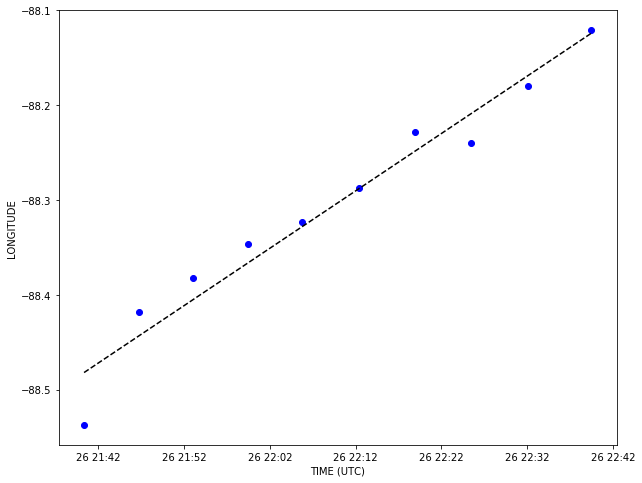

In [21]:
x = ts
y = lat_f10
w = lon_f10

fit_lat = polyfit(x,y,1)
fit_lon = polyfit(x,w,1)
fit_fn_lon = poly1d(fit_lon)
fit_fn_lat = poly1d(fit_lat)

fig = plt.figure(figsize=(10,8))

plt.plot(time_f10, y, 'ro', time_f10, fit_fn_lat(x), '--k')
plt.xlabel('TIME (UTC)')
plt.ylabel('LATITUDE')
plt.show()
plt.close()

fig = plt.figure(figsize=(10,8))
plt.plot(time_f10, w, 'bo', time_f10, fit_fn_lon(x), '--k')
plt.xlabel('TIME (UTC)')
plt.ylabel('LONGITUDE')
plt.show()
plt.close()

In [22]:
def lats_lons(minimum, maximum, interval):
    '''ADD COMMENTS ABOUT DEFINITION'''
    minimum = minimum
    maximum = maximum
    interval = interval
    arr = np.arange(minimum, maximum, interval) 
    my_time = []
    for i in arr:
        my_time.append(time[-1] + np.timedelta64(str(i), 'm'))
    my_new_time = np.array(my_time)
    nts = ((my_new_time - np.datetime64('1970-01-01T00:00:00Z')) 
           / np.timedelta64(1, 's'))
    my_new_lat = fit_fn_lat(nts)
    my_new_lon = fit_fn_lon(nts)
    print(my_new_lon)
    print(my_new_lat)
    return my_new_time, my_new_lat, my_new_lon

In [23]:
my_new_time, my_new_lat, my_new_lon = lats_lons(10,110,10)

['2018-06-26T22:49:28.000000000' '2018-06-26T22:59:28.000000000'
 '2018-06-26T23:09:28.000000000' '2018-06-26T23:19:28.000000000'
 '2018-06-26T23:29:28.000000000' '2018-06-26T23:39:28.000000000'
 '2018-06-26T23:49:28.000000000' '2018-06-26T23:59:28.000000000'
 '2018-06-27T00:09:28.000000000' '2018-06-27T00:19:28.000000000']
[ 41.43180629  41.49980952  41.56781275  41.63581597  41.7038192
  41.77182243  41.83982566  41.90782889  41.97583212  42.04383535]
[-88.06360213 -88.0030767  -87.94255126 -87.88202583 -87.82150039
 -87.76097496 -87.70044953 -87.63992409 -87.57939866 -87.51887322]


/home/jhemedinger/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  # This is added back by InteractiveShellApp.init_path()


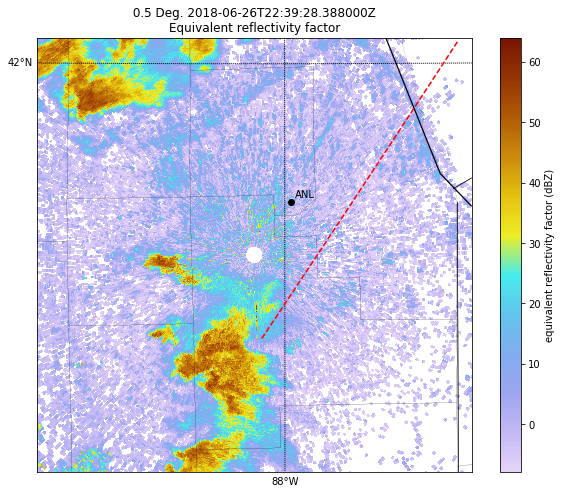

In [74]:
#animating using matplotlib and pyart
def animate(nframe):
    plt.clf()
    localfile = tempfile.NamedTemporaryFile()
    aws_radar.download_file(keys[nframe], localfile.name)
    radar = pyart.io.read(localfile.name)
    display = pyart.graph.RadarMapDisplay(radar)
    # Delete radar after use to save memory.
    del radar
    display.plot_ppi_map('reflectivity', sweep=0, resolution='l',
                         vmin=-8, vmax=64, mask_outside=True, 
                         fig=fig, width=100000, height=100000,
                         cmap=pyart.graph.cm.LangRainbow12)
    display.basemap.drawcounties()
    display.plot_line_geo(my_new_lon, my_new_lat, '--r')
#    display.plot_line_geo(lon_f10[:nframe], lat_f10[:nframe], '-k')
    display.plot_line_geo(lon_l10[:nframe], lat_l10[:nframe], '-k')
    display.plot_point(-87.981810, 41.713969 , label_text='ANL', symbol='ko')
#    display.plot_point(-87.04361, 41.46361, label_text='VU', color='k')
fig = plt.figure(figsize=(10, 8))

anim_klot = animation.FuncAnimation(fig, animate, 
                                    frames=len(keys))
anim_klot.save(out_path_dir + '/reflectivity_animation2.gif', 
               writer='imagemagick', fps=1)
plt.show()
plt.close()